In [1]:
import mne
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import json
import time

C:\Users\matth\AppData\Local\Temp\ipykernel_7012\1063997944.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


KeyboardInterrupt: 

In [2]:
mne.set_log_level('ERROR')

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


In [4]:
print(device)

cuda


In [5]:
# Used to read our json file of each dictionary mapped to its file name
def read_dict_from_json_file(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [6]:
class CHBData(Dataset):
    def __init__(self, segment_dict):
        self.segment_dict = segment_dict
        # Mapping label names to integers
        self.label_to_int = {'interictal': 0, 'preictal': 1, 'ictal': 2}

    def __len__(self):
        return len(self.segment_dict)

    def __getitem__(self, index):
        # Retrieve the label and map it to an integer
        segment_tensor = torch.load(f'CHB-MIT/Segments/chb01/{index}-chb01.pt')
        label_name = self.segment_dict[f'CHB-MIT/Segments/chb01/{index}-chb01.pt']
        label = self.label_to_int[label_name]
        segment_tensor = segment_tensor.to(device)
        return segment_tensor, label


In [7]:
segment_dict = read_dict_from_json_file('CHB-MIT/segment_dict1.json')


#hi

In [8]:
num_workers = 0
full_dataset = CHBData(segment_dict)

# Split the dataset into train and test sets
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42)

#  split the test set into validation and actual test sets
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42)

# dataloaders for training, validation, and test
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Instantiate dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)


In [9]:
class SeizureSense(nn.Module):
    
    def __init__(self):
        super(SeizureSense,self).__init__()
        
        #Block 1
        #should be taking in an input of 23x512
        #first layer temporal filters
        self.conv1=nn.Conv2d(1,8,(1,128),stride=1,padding=0)
        self.batchnorm1 = nn.BatchNorm2d(8, False)
        
        #spatial layer(depthwise layer)
        self.conv2=nn.Conv2d(8,32,(23,1))
        self.batchnorm2 = nn.BatchNorm2d(32, False)
        self.avgpool1 = nn.AvgPool2d((1,2))
        #apply dropout here in forward
        
        
        #Block 2
        #sepereable convolutional 2d
        self.conv3=nn.Conv2d(32,32,(1,16),stride=1)
        self.batchnorm3 = nn.BatchNorm2d(32,False) #CHECK THIS!
        self.avgpool2 = nn.AvgPool2d((1,16))

        
        #Block 3
        
        self.fc1= nn.Linear(96, 30)
        self.fc2=nn.Linear(30,3)

        #apply dropout here in forward
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):
        x=self.conv1(x)
        x =F.elu(x)
        x=self.batchnorm1(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = F.elu(x)
        x=self.batchnorm2(x)
        x = self.dropout(x)
        x=self.avgpool1(x)
        
        x=F.elu(self.conv3(x))
        x=self.batchnorm3(x)
        x = self.dropout(x)
        x=self.avgpool2(x)
        
        #Fully connected layers for classification
        x=x.view(-1,96)
        x=F.elu(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        return x

In [10]:
model=SeizureSense()
model.to(device)

SeizureSense(
  (conv1): Conv2d(1, 8, kernel_size=(1, 128), stride=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(23, 1), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool1): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (conv3): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1))
  (batchnorm3): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool2): AvgPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0)
  (fc1): Linear(in_features=96, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [11]:
#maps back the labels to words
def decode_predictions(predictions):
    label_names = ['interictal', 'preictal', 'ictal']
    _, predicted_labels = torch.max(predictions, 1)
    return [label_names[label] for label in predicted_labels]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Initialize lists to store metrics
epoch_losses = []
epoch_accuracies = []
epoch_recalls = []

num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    
    # Validation Phase
    model.eval()
    val_labels = []
    val_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions, average='macro')
    # For specificity, you need to calculate it manually or adjust the approach if binary classification
    
    epoch_accuracies.append(accuracy)
    epoch_recalls.append(recall)
    
    end_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Time: {end_time - start_time:.2f}s')

# Plotting function



In [22]:
torch.save(model.state_dict(), 'SeizureSenseStateDict.pth')

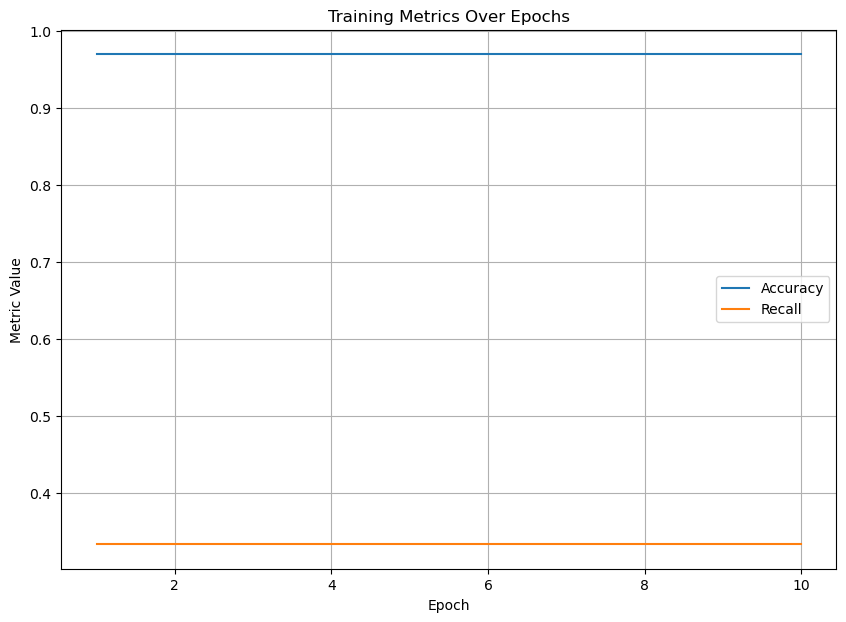

In [21]:
def plot_metrics(epochs, accuracies, recalls):
    plt.figure(figsize=(10, 7))
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.plot(epochs, recalls, label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Training Metrics Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Now calling the plot function
epochs = range(1, num_epochs + 1)
plot_metrics(epochs, epoch_accuracies, epoch_recalls)

In [22]:
print(accuracy)

0.9697094298245614
